Tham khảo:
* https://www.youtube.com/watch?v=5kgWyo6Sg4E
* https://mmdetection.readthedocs.io/en/3.x/get_started.html

# **1) Cài đặt Libraries**

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd /content

%pip install -U -q openmim

!mim install -q "mmengine>=0.6.0"
!mim install -q "mmcv>=2.0.0rc4,<2.1.0"
!mim install -q "mmdet>=3.0.0rc6,<3.1.0"

!git clone https://github.com/open-mmlab/mmyolo.git

%cd /content/mmyolo

%pip install -e .

In [ ]:
!pip install -q roboflow
!pip install -q supervision==0.13.0

In [ ]:
import cv2
import os
import json
import roboflow
import torch
import random
import supervision as sv
import numpy as np

from mmdet.apis import init_detector, inference_detector

# **2) Inference trên mô hình pre-trained RTMDet COCO**

Tham khảo mô hình: https://github.com/open-mmlab/mmyolo/tree/main/configs/rtmdet

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Configuration

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CONFIG_PATH = f"/content/mmyolo/configs/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco.py"
WEIGHTS_PATH = f"/content/gdrive/MyDrive/Khoa học dữ liệu ảnh: Nền tảng và Ứng dụng - IT2038.CH1801/Lab2/MMDetection/weights/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth"

### Load model

In [ ]:
model = init_detector(CONFIG_PATH, WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/weights/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth


### Inference

In [ ]:
IMAGE_PATH = f"/content/gdrive/MyDrive/Khoa học dữ liệu ảnh: Nền tảng và Ứng dụng - IT2038.CH1801/Lab2/MMDetection/data/dog.jpeg"

In [ ]:
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


**NOTE:** Let's use `supervision` to  detections.

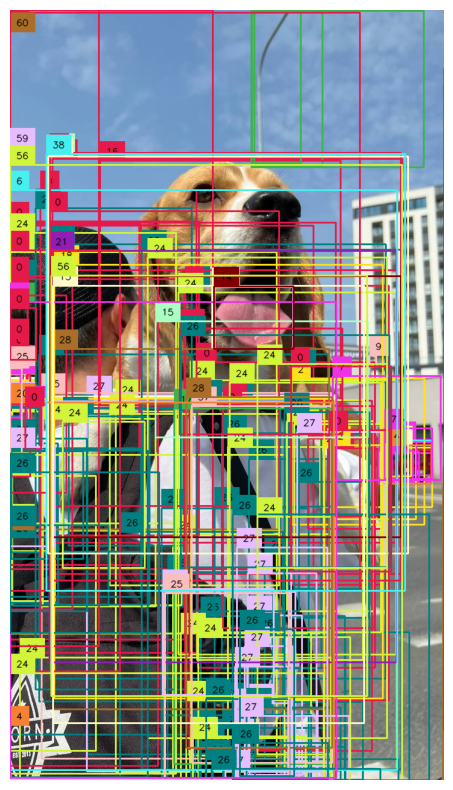

In [ ]:
detections = sv.Detections.from_mmdetection(result)
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

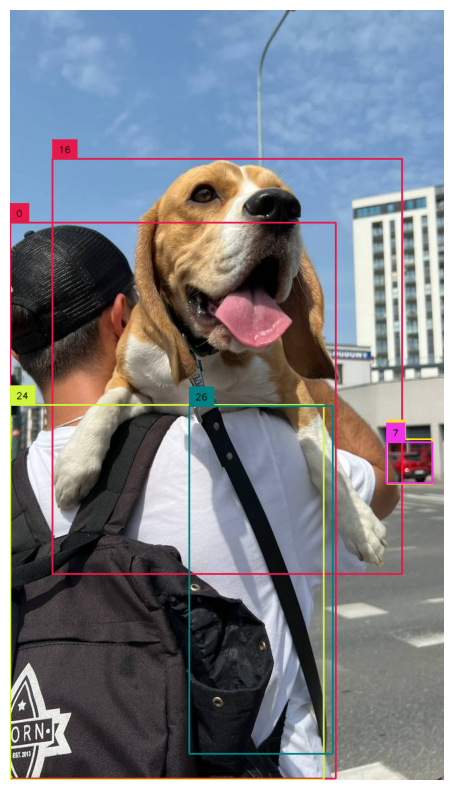

In [ ]:
detections = detections[detections.confidence > 0.3].with_nms()
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

# **3) Load dataset được hỗ trợ từ mmyolo**

In [ ]:
!mkdir -p /content/mmyolo/data
%cd /content/mmyolo/data

/content/mmyolo/data


In [ ]:
roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(2).download("coco-mmdetection")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to football-players-detection-2 in coco-mmdetection:: 100%|██████████| 671/671 [00:00<00:00, 2347.81it/s]


# **4) Training mô hình RTMDet trên tập dữ liệu về bóng đá**

Dựa vào file config, tiến hành chỉnh sửa file config đó

In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 50

In [ ]:
CUSTOM_CONFIG_PATH = f"/content/mmyolo/configs/rtmdet/custom.py"

CUSTOM_CONFIG = f"""
_base_ = ['../_base_/default_runtime.py', '../_base_/det_p5_tta.py']

# ========================Frequently modified parameters======================
# -----data related-----
data_root = '{dataset.location}/'

train_ann_file = 'train/_annotations.coco.json'
train_data_prefix = 'train/'

val_ann_file = 'valid/_annotations.coco.json'
val_data_prefix = 'valid/'

class_name = {tuple(sorted(project.classes.keys()))}
num_classes = {len(project.classes)}

metainfo = dict(classes=class_name, palette=[(20, 220, 60)])

train_batch_size_per_gpu = {BATCH_SIZE}
# Worker to pre-fetch data for each single GPU during training
train_num_workers = 4
# persistent_workers must be False if num_workers is 0.
persistent_workers = True

# -----train val related-----
# Base learning rate for optim_wrapper. Corresponding to 8xb16=64 bs
base_lr = 0.004
max_epochs = {MAX_EPOCHS}  # Maximum training epochs
# Change train_pipeline for final 20 epochs (stage 2)
num_epochs_stage2 = 20

model_test_cfg = dict(
    # The config of multi-label for multi-class prediction.
    multi_label=True,
    # The number of boxes before NMS
    nms_pre=30000,
    score_thr=0.001,  # Threshold to filter out boxes.
    nms=dict(type='nms', iou_threshold=0.65),  # NMS type and threshold
    max_per_img=300)  # Max number of detections of each image

# ========================Possible modified parameters========================
# -----data related-----
img_scale = (640, 640)  # width, height
# ratio range for random resize
random_resize_ratio_range = (0.1, 2.0)
# Cached images number in mosaic
mosaic_max_cached_images = 40
# Number of cached images in mixup
mixup_max_cached_images = 20
# Dataset type, this will be used to define the dataset
dataset_type = 'YOLOv5CocoDataset'
# Batch size of a single GPU during validation
val_batch_size_per_gpu = 32
# Worker to pre-fetch data for each single GPU during validation
val_num_workers = 10

# Config of batch shapes. Only on val.
batch_shapes_cfg = dict(
    type='BatchShapePolicy',
    batch_size=val_batch_size_per_gpu,
    img_size=img_scale[0],
    size_divisor=32,
    extra_pad_ratio=0.5)

# -----model related-----
# The scaling factor that controls the depth of the network structure
deepen_factor = 1.0
# The scaling factor that controls the width of the network structure
widen_factor = 1.0
# Strides of multi-scale prior box
strides = [8, 16, 32]

norm_cfg = dict(type='BN')  # Normalization config

# -----train val related-----
lr_start_factor = 1.0e-5
dsl_topk = 13  # Number of bbox selected in each level
loss_cls_weight = 1.0
loss_bbox_weight = 2.0
qfl_beta = 2.0  # beta of QualityFocalLoss
weight_decay = 0.05

# Save model checkpoint and validation intervals
save_checkpoint_intervals = 10
# validation intervals in stage 2
val_interval_stage2 = 1
# The maximum checkpoints to keep.
max_keep_ckpts = 3
# single-scale training is recommended to
# be turned on, which can speed up training.
env_cfg = dict(cudnn_benchmark=True)

# ===============================Unmodified in most cases====================
# https://mmengine.readthedocs.io/en/latest/api/visualization.html
_base_.visualizer.vis_backends = [
    dict(type='LocalVisBackend'), #
    dict(type='TensorboardVisBackend'),]

model = dict(
    type='YOLODetector',
    data_preprocessor=dict(
        type='YOLOv5DetDataPreprocessor',
        mean=[103.53, 116.28, 123.675],
        std=[57.375, 57.12, 58.395],
        bgr_to_rgb=False),
    backbone=dict(
        type='CSPNeXt',
        arch='P5',
        expand_ratio=0.5,
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        channel_attention=True,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    neck=dict(
        type='CSPNeXtPAFPN',
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        in_channels=[256, 512, 1024],
        out_channels=256,
        num_csp_blocks=3,
        expand_ratio=0.5,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    bbox_head=dict(
        type='RTMDetHead',
        head_module=dict(
            type='RTMDetSepBNHeadModule',
            num_classes=num_classes,
            in_channels=256,
            stacked_convs=2,
            feat_channels=256,
            norm_cfg=norm_cfg,
            act_cfg=dict(type='SiLU', inplace=True),
            share_conv=True,
            pred_kernel_size=1,
            featmap_strides=strides),
        prior_generator=dict(
            type='mmdet.MlvlPointGenerator', offset=0, strides=strides),
        bbox_coder=dict(type='DistancePointBBoxCoder'),
        loss_cls=dict(
            type='mmdet.QualityFocalLoss',
            use_sigmoid=True,
            beta=qfl_beta,
            loss_weight=loss_cls_weight),
        loss_bbox=dict(type='mmdet.GIoULoss', loss_weight=loss_bbox_weight)),
    train_cfg=dict(
        assigner=dict(
            type='BatchDynamicSoftLabelAssigner',
            num_classes=num_classes,
            topk=dsl_topk,
            iou_calculator=dict(type='mmdet.BboxOverlaps2D')),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    test_cfg=model_test_cfg,
)

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Mosaic',
        img_scale=img_scale,
        use_cached=True,
        max_cached_images=mosaic_max_cached_images,
        pad_val=114.0),
    dict(
        type='mmdet.RandomResize',
        # img_scale is (width, height)
        scale=(img_scale[0] * 2, img_scale[1] * 2),
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(
        type='YOLOv5MixUp',
        use_cached=True,
        max_cached_images=mixup_max_cached_images),
    dict(type='mmdet.PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='mmdet.RandomResize',
        scale=img_scale,
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(type='mmdet.PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='YOLOv5KeepRatioResize', scale=img_scale),
    dict(
        type='LetterResize',
        scale=img_scale,
        allow_scale_up=False,
        pad_val=dict(img=114)),
    dict(type='LoadAnnotations', with_bbox=True, _scope_='mmdet'),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor', 'pad_param'))
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    collate_fn=dict(type='yolov5_collate'),
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=train_ann_file,
        data_prefix=dict(img=train_data_prefix),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline))

val_dataloader = dict(
    batch_size=val_batch_size_per_gpu,
    num_workers=val_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=val_ann_file,
        data_prefix=dict(img=val_data_prefix),
        test_mode=True,
        batch_shapes_cfg=batch_shapes_cfg,
        pipeline=test_pipeline))

test_dataloader = val_dataloader

# Reduce evaluation time
val_evaluator = dict(
    type='mmdet.CocoMetric',
    proposal_nums=(100, 1, 10),
    ann_file=data_root + val_ann_file,
    metric='bbox')
test_evaluator = val_evaluator

# optimizer
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=weight_decay),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=lr_start_factor,
        by_epoch=False,
        begin=0,
        end=1000),
    dict(
        # use cosine lr from 150 to 300 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# hooks
default_hooks = dict(
    checkpoint=dict(
        type='CheckpointHook',
        interval=save_checkpoint_intervals,
        max_keep_ckpts=max_keep_ckpts  # only keep latest 3 checkpoints
    ))

custom_hooks = [
    dict(
        type='EMAHook',
        ema_type='ExpMomentumEMA',
        momentum=0.0002,
        update_buffers=True,
        strict_load=False,
        priority=49),
    dict(
        type='mmdet.PipelineSwitchHook',
        switch_epoch=max_epochs - num_epochs_stage2,
        switch_pipeline=train_pipeline_stage2)
]

train_cfg = dict(
    type='EpochBasedTrainLoop',
    max_epochs=max_epochs,
    val_interval=save_checkpoint_intervals,
    dynamic_intervals=[(max_epochs - num_epochs_stage2, val_interval_stage2)])

val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')
"""

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

Tiến hành huấn luyện mô hình

In [ ]:
%cd /content/mmyolo
!python tools/train.py configs/rtmdet/custom.py

## Load lại mô hình vừa được huấn luyện

In [ ]:
CUSTOM_WEIGHTS_PATH = f"/content/mmyolo/work_dirs/custom/epoch_{MAX_EPOCHS}.pth"

In [ ]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/mmyolo/work_dirs/custom/epoch_50.pth


## Inference trên mô hình vừa huấn luyện

In [ ]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

images = list(ds.images.values())

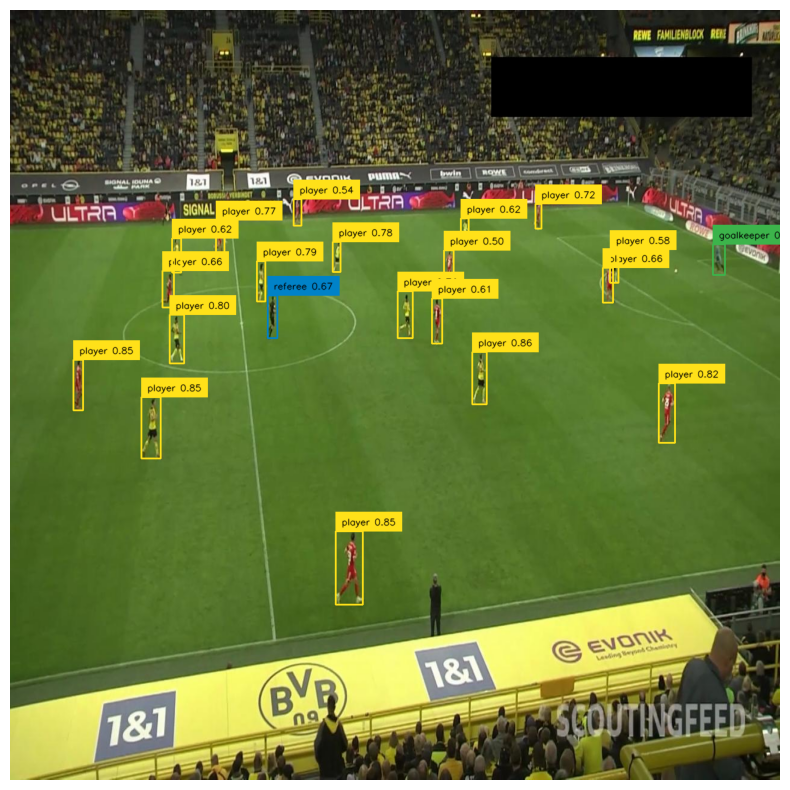

In [ ]:
import time
image = random.choice(images)
start_time = time.time()
result = inference_detector(model, image)
detections = sv.Detections.from_mmdetection(result)
detections = detections[detections.confidence > 0.4].with_nms()
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

box_annotator = sv.BoxAnnotator()
labels = [
    f"{ds.classes[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]
annotated_image = box_annotator.annotate(image.copy(), detections, labels=labels)
sv.plot_image(image=annotated_image, size=(10, 10))